In [1]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
def read_dataframe(filename):

    # read parquet file
    df = pd.read_parquet(filename)

    # data shape
    print(f"Data shape: {df.shape}")

    # calculate the trip duration in minutes
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime

    # convert from seconds to minutes
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    # create a copy of the dataframe
    df_copy = df.copy(deep = True)

    # mean of the filtered duration
    duration_mean = ((df.duration >= 1) & (df.duration <= 60)).mean()
    print(f"Percentage of the filtered duration data: {duration_mean*100:.2f}%")
    
    # remove outliers
    df = df[(df.duration >=1) & (df.duration <=60)]

    # selecting variables
    categorical = ['PULocationID', 'DOLocationID']
    
    # convert to a string
    df[categorical] = df[categorical].astype(str)

    return df, df_copy

In [3]:
# loading data

# data from january
df_train, df_train_copy = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")

# data from february
df_val, df_val_copy = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")

Data shape: (3066766, 19)
Percentage of the filtered duration data: 98.12%
Data shape: (2913955, 19)
Percentage of the filtered duration data: 98.01%


#### Question 1 [Downloading the data]:

Read the data for January. How many columns are there?

Answer: 19

#### Question 2 [Computing duration]: 

What's the standard deviation of the trips duration in January?

Answer: 42.59

In [4]:
df_train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [5]:
df_val.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.00,0.0,1.0,9.40,2.5,0.00,1.683333
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.00,0.0,1.0,74.65,0.0,1.25,32.083333
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.30,0.0,1.0,25.30,2.5,0.00,13.300000
5,1,2023-02-01 00:52:40,2023-02-01 01:07:18,1.0,5.10,1.0,N,148,236,1,21.9,3.50,0.5,5.35,0.0,1.0,32.25,2.5,0.00,14.633333
6,1,2023-02-01 00:12:39,2023-02-01 00:40:36,1.0,8.90,1.0,N,137,244,1,41.5,3.50,0.5,3.50,0.0,1.0,50.00,2.5,0.00,27.950000


In [6]:
# checking for null values in 'duration'
df_train.duration.isnull().sum()

0

In [7]:
# checking for null values in 'duration'
df_val.duration.isnull().sum()

0

In [8]:
# standard deviation of January's duration
df_train_copy.duration.std()

42.594351241920904

#### Question 3 [Dropping outliers]: 

What fraction of the records left after you dropped the outliers?

Answer: 98%

/tmp/ipykernel_79320/652934418.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train_copy.duration)


<Axes: xlabel='duration', ylabel='Density'>

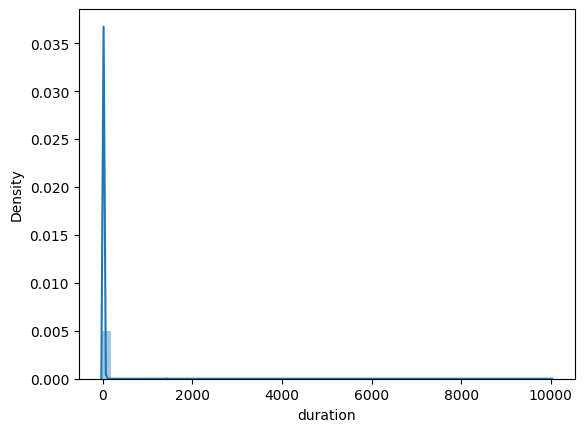

In [9]:
# plot the distribution of the duration with outliers 
sns.distplot(df_train_copy.duration)

/tmp/ipykernel_79320/3405527495.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.duration)


<Axes: xlabel='duration', ylabel='Density'>

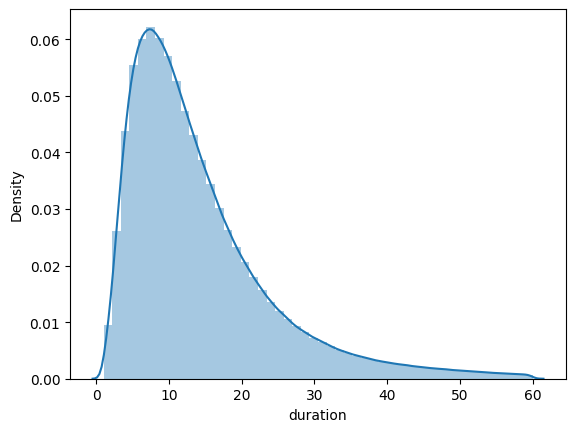

In [10]:
# plot the distribution of the duration without outliers 
sns.distplot(df_train.duration)

/tmp/ipykernel_79320/248571169.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_val_copy.duration)


<Axes: xlabel='duration', ylabel='Density'>

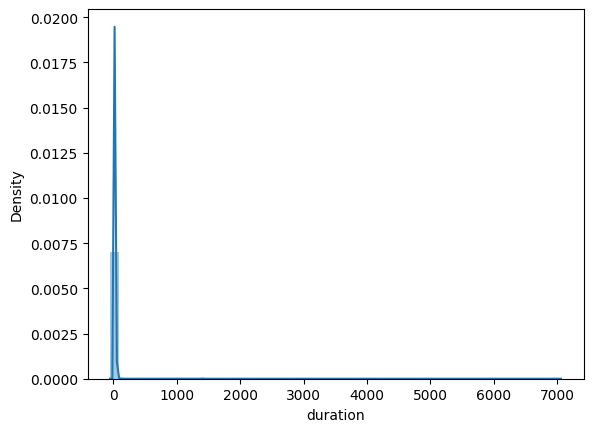

In [11]:
# plot the distribution of the duration with outliers
sns.distplot(df_val_copy.duration)

/tmp/ipykernel_79320/294186978.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_val.duration)


<Axes: xlabel='duration', ylabel='Density'>

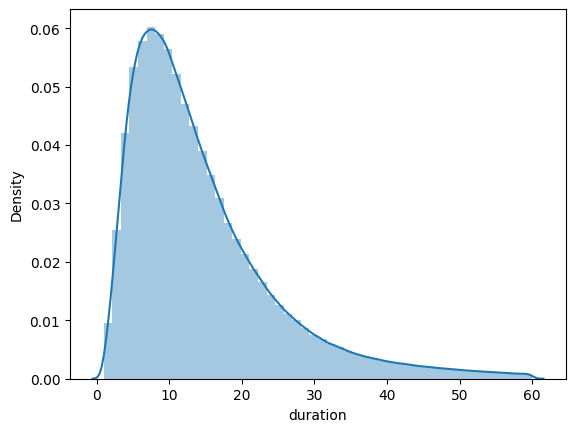

In [12]:
# plot the distribution of the duration without outliers
sns.distplot(df_val.duration)

#### Question 4 [One-hot encoding]: 
What's the dimensionality of the feature matrix (number of columns)?

Answer: 515

In [13]:
df_train.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'duration'],
      dtype='object')

In [14]:
def preprocessing(df_train, df_val):

    # selecting variables
    categorical = ['PULocationID', 'DOLocationID']
    
    # # convert to a string
    # df[categorical] = df[categorical].astype(str)

    # inicialize an instance
    dict_vet = DictVectorizer()

    # convert the features from dataframes to dictionaries (rows) - train set
    train_dicts = df_train[categorical].to_dict(orient='records')

    # build train data
    X_train = dict_vet.fit_transform(train_dicts)

    # convert the features from dataframes to dictionaries (rows) - validation set
    val_dicts = df_val[categorical].to_dict(orient='records')

    # build validation data
    X_val = dict_vet.transform(val_dicts)

    # target variable
    target = 'duration'

    # train and validation labels
    y_train = df_train[target].values
    y_val = df_val[target].values

    return X_train, X_val, y_train, y_val 

In [15]:
# preprocess the data and build the train and validation sets
X_train, X_val, y_train, y_val = preprocessing(df_train, df_val)

In [16]:
print(f"Matrix dimensions - train set: {X_train.shape}, validation set: {X_val.shape}")

Matrix dimensions - train set: (3009173, 515), validation set: (2855951, 515)


In [17]:
y_train.shape, y_val.shape

((3009173,), (2855951,))

In [18]:
def train_data(X_train, X_val, y_train, y_val):

    # initialize model
    linear_regression = LinearRegression()

    # fit the model
    linear_regression.fit(X_train, y_train)

    # calculate the prediction on the training set
    y_pred_train = linear_regression.predict(X_train)

    # evaluate the model - training data
    RMSE_train = root_mean_squared_error(y_train, y_pred_train)

    # calculate the prediction on the evaluation set
    y_pred_ev = linear_regression.predict(X_val)

    # evaluate the model - evaluation data
    RMSE_ev = root_mean_squared_error(y_val, y_pred_ev)
    

    return RMSE_train, RMSE_ev

In [19]:
# training the model and calculating the RMSE
# on the training set
RMSE_train, RMSE_ev = train_data(X_train, X_val, y_train, y_val)
print(f"RMSE - training set: {RMSE_train}")
print(f"RMSE - validation set: {RMSE_ev}")

RMSE - training set: 7.649261932106969
RMSE - validation set: 7.811818743246608


#### Question 5 [Training a model]: 
What's the RMSE on train?

Answer: 7.64

#### Question 6 [Evaluation the model]: 
What's the RMSE on validation?

Answer: 7.81